# Import data

In [1]:
#!pip install image-classifiers
import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import seaborn as sns
from sklearn import datasets, metrics

%matplotlib inline

Using TensorFlow backend.


# Classificando imagens em Fuit 360

explain dataset

## Lendo o conjunto de dados

In [2]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = './fruits-360'
target_size = (100, 100)
input_shape = (100, 100, 3)
classes = ["Apple Braeburn","Apple Crimson Snow","Apple Golden 1","Apple Golden 2","Apple Golden 3","Apple Granny Smith","Apple Pink Lady","Apple Red 1","Apple Red 2","Apple Red 3",
           "Apple Red Delicious","Apple Red Yellow 1","Apple Red Yellow 2","Apricot","Avocado","Avocado ripe","Banana","Banana Lady Finger","Banana Red","Cactus fruit","Cantaloupe 1",
           "Cantaloupe 2","Carambula","Cherry 1","Cherry 2","Cherry Rainier","Cherry Wax Black","Cherry Wax Red","Cherry Wax Yellow","Chestnut","Clementine","Cocos","Dates","Granadilla",
           "Grape Blue","Grape Pink","Grape White","Grape White 2","Grape White 3","Grape White 4","Grapefruit Pink","Grapefruit White","Guava","Hazelnut","Huckleberry","Kaki","Kiwi",
           "Kohlrabi","Kumquats","Lemon","Lemon Meyer","Limes","Lychee","Mandarine","Mango","Mangostan","Maracuja","Melon Piel de Sapo","Mulberry","Nectarine","Orange","Papaya","Passion Fruit",
           "Peach","Peach 2","Peach Flat","Pear","Pear Abate","Pear Kaiser","Pear Monster","Pear Red","Pear Williams","Pepino","Pepper Green","Pepper Red","Pepper Yellow","Physalis",
           "Physalis with Husk","Pineapple","Pineapple Mini","Pitahaya Red","Plum","Plum 2","Plum 3","Pomegranate","Pomelo Sweetie","Quince","Rambutan","Raspberry","Redcurrant","Salak",
           "Strawberry","Strawberry Wedge","Tamarillo","Tangelo","Tomato 1","Tomato 2","Tomato 3","Tomato 4","Tomato Cherry Red","Tomato Maroon","Tomato Yellow","Walnut"]


sample_generator = sample_datagen.flow_from_directory(base_path + '/Training',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/Test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % (np.max(sample_generator.labels) + 1),
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)

Found 53177 images belonging to 103 classes.
Found 17845 images belonging to 103 classes.


Showing y sample: [ 16.  44.  62.  69.  14.  62.  70.  86.  56.  38.  19.  41.  90.  60.
  99.  11. 102.  47.  11.  80.  91. 101.  35.  93.  48.  43. 100.  11.
  36.  73.  93. 102.]


samples in train: 53177
samples in test: 17845
features: (100, 100, 3)
classes: 103

shape: (32, 100, 100, 3) (32, 100, 100, 3)


## Lendo as 32 primeiras amostras no conjunto de treinamento

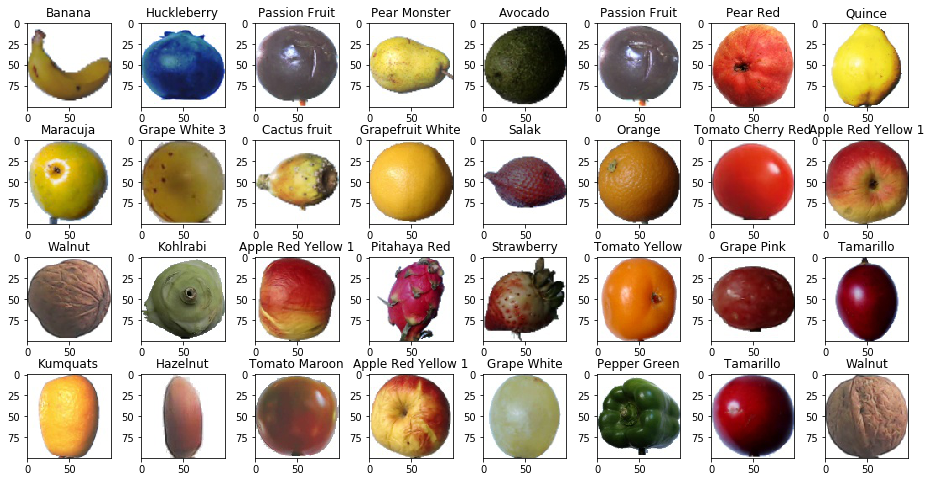

In [3]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

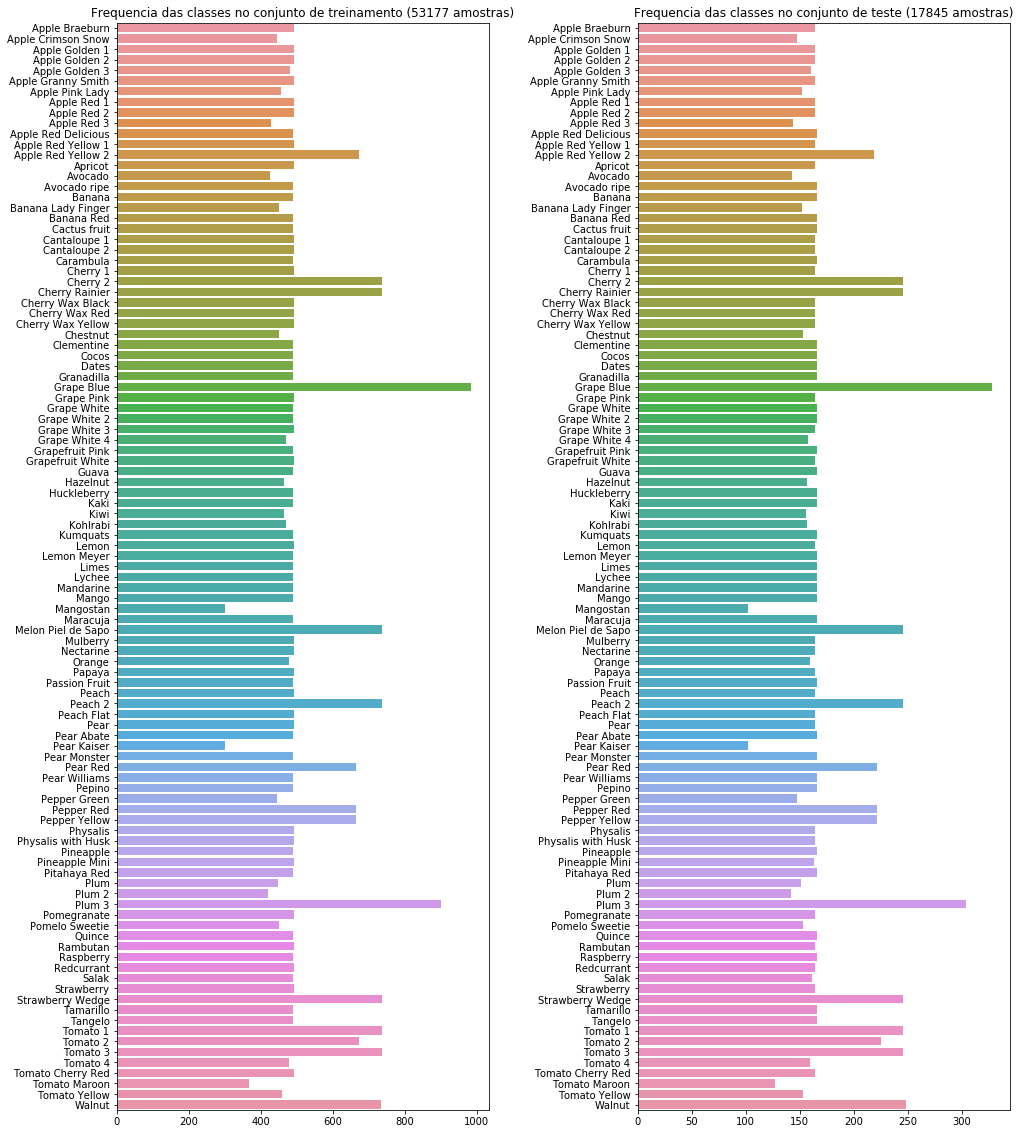

In [4]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes)

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [5]:
train_batch_size = 501 # Selecionar um divisor do número de amostras (1 3 5 15 17 51 85 167 255 501 835 2505 2839 8517 14195 42585)
val_batch_size = 379 # Selecionar um divisor do número de amostras (1 2 4 7 14 28 379 758 1516 2653 5306 10612)
test_batch_size = 215 # Selecionar um divisor do número de amostras (1 5 43 83 215 415 3569 17845)

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/Training",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/Training",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(base_path + "/Test",
                                                  target_size = target_size,
                                                  batch_size = test_batch_size,
                                                  class_mode = "categorical")

Found 42569 images belonging to 103 classes.
Found 10608 images belonging to 103 classes.
Found 17845 images belonging to 103 classes.


# Parâmetros para treinamento e validação

In [6]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

epochs = 8

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

test_steps = test_generator.samples // test_batch_size

Instructions for updating:
Colocations handled automatically by placer.


# Funções de auxílio

In [7]:
df_resultado = pd.DataFrame(columns=["Rede", 
                                     "train_acc", 
                                     "train_loss", 
                                     "val_acc", 
                                     "val_loss"])
def salvar_resultado(rede,
                     train_acc,
                     train_loss,
                     val_acc,
                     val_loss,
                     df = df_resultado):
  
    df = df.append({"Rede" : rede,
                    "train_acc": train_acc,
                    "train_loss" : train_loss,
                    "val_acc": val_acc,
                    "val_loss": val_loss
                   }, 
                   ignore_index = True)
    return df

In [30]:
def train_model(model, 
                name, 
                train_g = train_generator, 
                validation_g = validation_generator, 
                factor = 1,
                train_epochs = epochs):
  train_g.reset()
  validation_g.reset()
  new_epoch = train_epochs * factor
  patience = new_epoch // 3
  with tf.device(device):
      return model.fit_generator(generator = train_g,
                                 steps_per_epoch = train_steps / factor,
                                 epochs = new_epoch,
                                 verbose = 1,
                                 validation_data = validation_g,
                                 validation_steps = validation_steps,
                                 callbacks=[callbacks.TerminateOnNaN(),
                                            callbacks.ReduceLROnPlateau(patience = patience),
                                            callbacks.EarlyStopping(patience = patience,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)])

In [31]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [32]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [33]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [34]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [35]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [36]:
def evaluate_model(model, name, generator = test_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  val_score = evaluate_generator_model(model, name + '_val', generator, steps)
  train_score = evaluate_generator_model(model, name + '_train', train_generator, train_steps)
  
  print('*** Saving results - Part (5/5)****')
  salvar_resultado(name, train_score[1], train_score[0], val_score[1], val_score[0])

In [37]:
def v(model, name, egenerator = validation_generator, steps = test_batch_size):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  evaluate_generator_model(model, name + '_val', generator, steps)

# Rede *Homemade*

## Definindo a rede

In [38]:
def build_homemade():
  model = Sequential()

  model.add(Conv2D(filters = 10,
                      kernel_size = [3, 3],
                      name = "conv_1",
                      activation = "relu",
                      input_shape = input_shape))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_1"))

  model.add(Conv2D(filters = 20,
                       kernel_size = [3, 3],
                       name = "conv_2",
                       activation = "relu"))
  model.add(Dropout(rate = 0.5, name = "do_1"))
  model.add(MaxPool2D(pool_size = [2, 2], name = "pool_2"))

  model.add(Flatten())
  model.add(Dense(units = 103,name = "dense_1", activation = 'softmax'))

  model.compile(optimizer = rms,
                    loss = 'categorical_crossentropy',
                    metrics=['accuracy'])

  model.summary()
  return model;

homemade_model = build_homemade()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 98, 98, 10)        280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 49, 49, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 47, 47, 20)        1820      
_________________________________________________________________
do_1 (Dropout)               (None, 47, 47, 20)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 23, 23, 20)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10580)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 103)               1089843   
Total para

## Treinando o modelo

In [39]:
history_homemade = train_model(homemade_model, name =  'homemade', factor = 20)

Epoch 1/160
5/4 [===================================] - 20s 4s/step - loss: 4.5425 - acc: 0.0271 - val_loss: 4.4708 - val_acc: 0.0436
Epoch 2/160
5/4 [===================================] - 17s 3s/step - loss: 4.2566 - acc: 0.0878 - val_loss: 4.3197 - val_acc: 0.0714
Epoch 3/160
5/4 [===================================] - 17s 3s/step - loss: 3.9707 - acc: 0.1549 - val_loss: 4.1491 - val_acc: 0.1717
Epoch 4/160
5/4 [===================================] - 18s 4s/step - loss: 3.7201 - acc: 0.2220 - val_loss: 3.9938 - val_acc: 0.1795
Epoch 5/160
5/4 [===================================] - 17s 3s/step - loss: 3.4507 - acc: 0.2890 - val_loss: 3.8204 - val_acc: 0.2503
Epoch 6/160
5/4 [===================================] - 17s 3s/step - loss: 3.1980 - acc: 0.3345 - val_loss: 3.6530 - val_acc: 0.3429
Epoch 7/160
5/4 [===================================] - 17s 3s/step - loss: 2.9511 - acc: 0.3756 - val_loss: 3.5146 - val_acc: 0.3564
Epoch 8/160
5/4 [===================================] - 17s 3s

5/4 [===================================] - 5s 1s/step - loss: 0.1684 - acc: 0.9649 - val_loss: 0.7690 - val_acc: 0.8380
Epoch 63/160
5/4 [===================================] - 5s 1s/step - loss: 0.1856 - acc: 0.9565 - val_loss: 0.7490 - val_acc: 0.8487
Epoch 64/160
5/4 [===================================] - 5s 1s/step - loss: 0.1820 - acc: 0.9533 - val_loss: 0.7194 - val_acc: 0.8648
Epoch 65/160
5/4 [===================================] - 5s 1s/step - loss: 0.1907 - acc: 0.9501 - val_loss: 0.6857 - val_acc: 0.8701
Epoch 66/160
5/4 [===================================] - 5s 1s/step - loss: 0.1526 - acc: 0.9657 - val_loss: 0.6628 - val_acc: 0.8699
Epoch 67/160
5/4 [===================================] - 5s 1s/step - loss: 0.1410 - acc: 0.9697 - val_loss: 0.6987 - val_acc: 0.8425
Epoch 68/160
5/4 [===================================] - 5s 1s/step - loss: 0.1300 - acc: 0.9711 - val_loss: 0.6236 - val_acc: 0.8901
Epoch 69/160
5/4 [===================================] - 5s 1s/step - loss:

5/4 [===================================] - 5s 1s/step - loss: 0.0220 - acc: 0.9984 - val_loss: 0.4408 - val_acc: 0.9025
Epoch 124/160
5/4 [===================================] - 5s 1s/step - loss: 0.0235 - acc: 0.9940 - val_loss: 0.4296 - val_acc: 0.9131
Epoch 125/160
5/4 [===================================] - 5s 1s/step - loss: 0.0268 - acc: 0.9956 - val_loss: 0.4231 - val_acc: 0.8967
Epoch 126/160
5/4 [===================================] - 5s 1s/step - loss: 0.0370 - acc: 0.9904 - val_loss: 0.4663 - val_acc: 0.8516
Epoch 127/160
5/4 [===================================] - 5s 1s/step - loss: 0.0445 - acc: 0.9872 - val_loss: 0.4145 - val_acc: 0.9154
Epoch 128/160
5/4 [===================================] - 5s 1s/step - loss: 0.0169 - acc: 0.9980 - val_loss: 0.4125 - val_acc: 0.9177
Epoch 129/160
5/4 [===================================] - 5s 1s/step - loss: 0.0226 - acc: 0.9944 - val_loss: 0.3934 - val_acc: 0.9261
Epoch 130/160
5/4 [===================================] - 5s 1s/step 

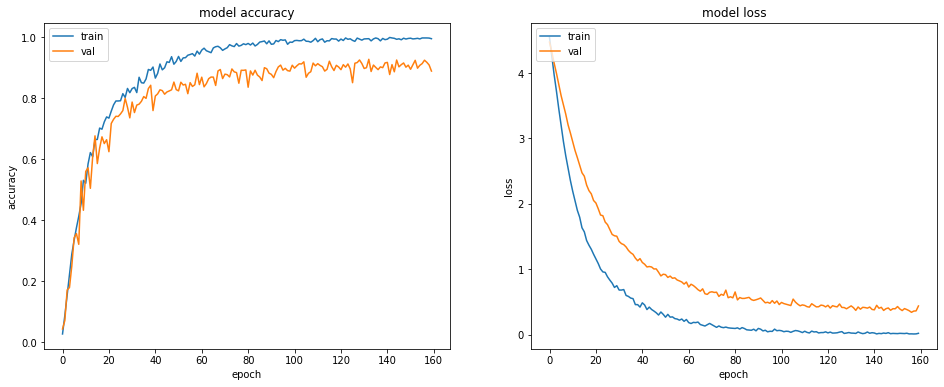

In [40]:
learning_curve_model(history_homemade)

## Avaliando modelo treinado

*** Prediction model - Part (1/5)****
*** Classification model - Part (2/5)****
                     precision    recall  f1-score   support

     Apple Braeburn       1.00      0.65      0.79      1303
 Apple Crimson Snow       1.00      1.00      1.00      1174
     Apple Golden 1       0.78      0.66      0.71      1306
     Apple Golden 2       0.81      1.00      0.90      1310
     Apple Golden 3       0.70      0.95      0.81      1281
 Apple Granny Smith       0.93      0.97      0.95      1302
    Apple Pink Lady       0.99      1.00      1.00      1210
        Apple Red 1       0.89      0.73      0.80      1298
        Apple Red 2       0.92      0.61      0.73      1305
        Apple Red 3       0.86      1.00      0.93      1148
Apple Red Delicious       0.99      1.00      1.00      1321
 Apple Red Yellow 1       1.00      0.75      0.86      1304
 Apple Red Yellow 2       1.00      1.00      1.00      1745
            Apricot       0.98      1.00      0.99      1305
    

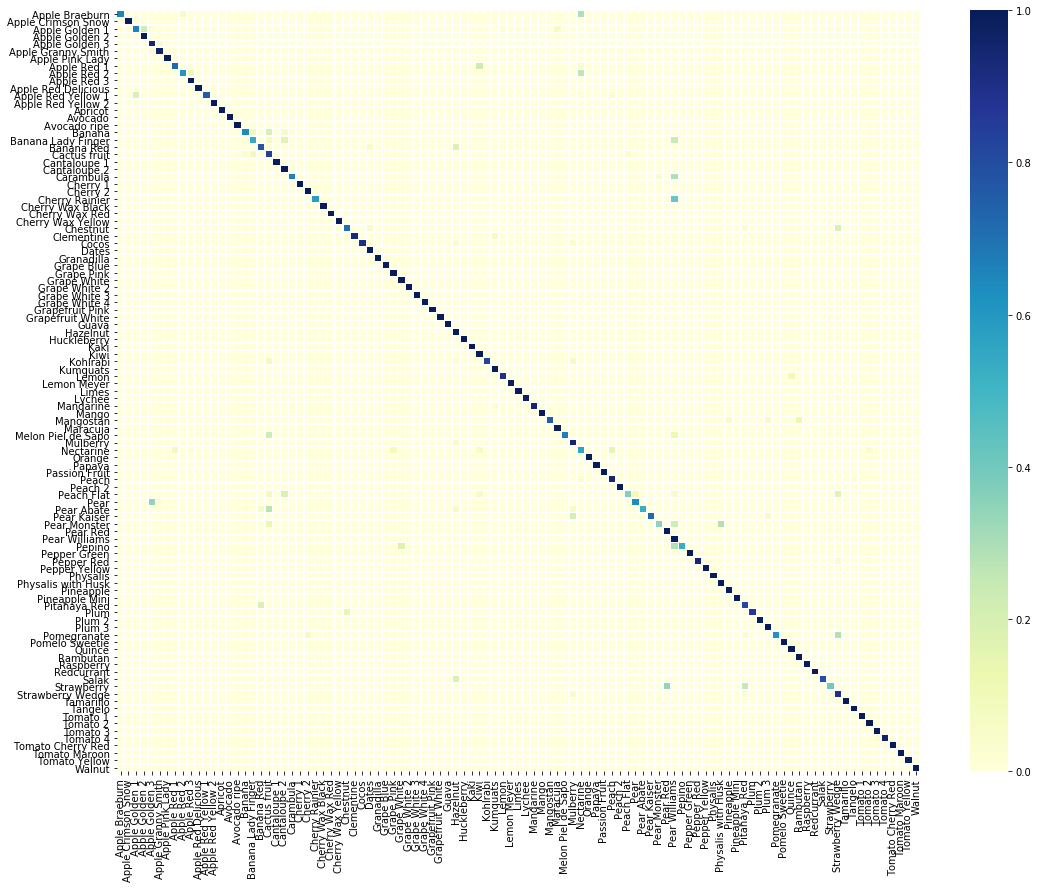


Classes incorretamente classificadas pelo modelo, com maior frequência:
  Pear Monster: 0.3511450381679389
 Peach Flat: 0.36579754601226994
 Strawberry: 0.40275650842266464
 Pepino: 0.5288315629742033
 Pear Abate: 0.5298563869992441
 Banana Lady Finger: 0.5384615384615384
 Nectarine: 0.5621165644171779
 Cherry Rainier: 0.5815856777493607
 Apple Red 2: 0.6084291187739463
 Pomegranate: 0.6162701458173446


Classes incorretamente classificadas pelo modelo, com menor frequência:
  Walnut: 1.0
 Granadilla: 1.0
 Grape White: 1.0
 Grape White 2: 1.0
 Grape White 3: 1.0
 Grape White 4: 1.0
 Grapefruit Pink: 1.0
 Grapefruit White: 1.0
 Guava: 1.0
 Hazelnut: 1.0

*** Evaluate model - Part (4/5)****
[Homemade_val] loss: 0.41050196908138414
[Homemade_val] accuracy (NOT BALANCED): 0.9037037006130925
[Homemade_train] loss: 0.07265256043700945
[Homemade_train] accuracy (NOT BALANCED): 0.9923724028326216
*** Saving results - Part (5/5)****


In [41]:
evaluate_model(homemade_model, 'Homemade')

# ResNet18 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from classification_models.resnet import ResNet18, preprocess_input

def build_resNet18():
  model = ResNet18(input_shape = input_shape,
                   weights = "imagenet",
                   include_top=False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input, outputs = output)

  model.compile(loss ='categorical_crossentropy', 
                optimizer = rms, 
                metrics=['accuracy'])
  
  model.summary()
  return model

resNet18_feature_model = build_resNet18()

## Fine Tuning

### Definindo a rede

In [0]:
def build_resNet18_tuning():
  model = build_resNet18()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model

resNet18_tunning_model = build_resNet18_tuning()

### Treinando o modelo

In [0]:
history_resNet18_tuning = train_model(resNet18_tunning_model, name =  'ResNet18 - Tuning', factor = 10)

In [0]:
learning_curve_model(history_resNet18_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(resNet18_tunning_model, 'ResNet18 - Tuning')

# VGG16 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

def build_vgg16_feature():
  model = VGG16(input_shape = input_shape,
                      weights = "imagenet",
                      include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                      outputs = output)

  model.compile(loss ='categorical_crossentropy',
                      optimizer = rms,
                      metrics=['accuracy'])

  model.summary()
  return model

vgg16_feature_model = build_vgg16_feature()

## Fine Tuning

### Definindo a rede

In [0]:
def build_vgg16_tuning():
  model = build_vgg16_feature()

  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                optimizer = rms,
                metrics=['accuracy'])

  model.summary()
  return model
  
vgg16_tunning_model = build_vgg16_tuning();

### Treinando o modelo

In [0]:
history_vgg16_tuning = train_model(vgg16_tunning_model, name =  'VGG16 - Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_vgg16_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(vgg16_tunning_model, 'VGG16 - Tunning')

# InceptionV3 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input


def build_inceptionV3_feature_model():
  model = InceptionV3(input_shape = input_shape,
                                  weights = "imagenet",
                                  include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                            outputs = output)

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_feature_model = build_inceptionV3_feature_model()

## Fine Tuning

### Definindo a rede

In [0]:
def build_inceptionV3_tunning_model():
  model = build_inceptionV3_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                            optimizer = rms,
                            metrics=['accuracy'])

  model.summary()
  return model

inceptionv3_tunning_model = build_inceptionV3_tunning_model()

### Treinando o modelo

In [0]:
history_inceptionv3_tuning = train_model(inceptionv3_tunning_model, name =  'InceptionV3 - Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_inceptionv3_tuning)

### Avaliando modelo treinado

In [0]:
evaluate_model(inceptionv3_tunning_model, 'InceptionV3 - Tunning')

# MobileNetV2 - Transfer Learning

## Feature Extraction

### Definindo a rede

In [0]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

def build_mobileNet_feature_model():
  model = MobileNetV2(input_shape = input_shape,
                                weights = "imagenet",
                                include_top = False)

  for layer in model.layers:
      layer.trainable = False

  output = model.output

  output = Flatten(name = 'flat_mdc')(output)

  output = Dense(103,
                 activation ='softmax',
                 name = 'saida_mdc')(output)

  model = Model(inputs = model.input,
                          outputs = output)

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_feature_model = build_mobileNet_feature_model()

## Fine Tuning

### Definindo a rede

In [0]:
def build_mobileNet_tunning_model():
  model = build_mobileNet_feature_model()
  for layer in model.layers:
      layer.trainable = True

  model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

  model.summary()
  return model

mobileNet_tunning_model = build_mobileNet_tunning_model()

### Treinando o modelo

In [0]:
history_mobileNet_tunning = train_model(mobileNet_tunning_model, name =  'MobileNet- Tunning', factor = 10, train_epochs = 16)

In [0]:
learning_curve_model(history_mobileNet_tunning)

### Avaliando modelo treinado

In [0]:
evaluate_model(mobileNet_tunning_model, 'MobileNet - Tunning')

# Avaliando as redes

## Comparando resultados das redes propostas

In [0]:
df_resultado.sort_values(by=["val_acc"])

## Avaliando no conjunto de teste(a melhor rede)

In [0]:
evaluate_test_model(history_resNet18_tuning, 'MobileNet - Tunning')